# Logit and LLR clipping: evidence collapse and a shadow-channel remedy

Clipping logits or log-likelihood ratios prevents overflow, but it can collapse distinct evidence histories onto the same stored value. This notebook demonstrates an identifiability failure caused by clipping, and introduces a minimal shadow channel that records discarded evidence online, restoring identifiability within the clipped subset.

In [11]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Optional: nicer tables (falls back to plain printing if unavailable)
try:
    import pandas as pd
except Exception:
    pd = None

# ZIA import (assume the implementation is in the same directory as this notebook)
import zia

# Reproducibility and demo constants
rng = np.random.default_rng(0)
L = 20.0        # clip bound (kept small for visual clarity)
n_timesteps = 60

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
try:
    import sklearn
    print("scikit-learn:", sklearn.__version__)
except Exception:
    print("scikit-learn: <unknown>")

print("L:", L)
print("n_timesteps:", n_timesteps)


Python: 3.13.0
NumPy: 2.3.5
scikit-learn: 1.8.0
L: 20.0
n_timesteps: 60


## Impossibility result for clipped representations

Let e be an evidence history (for example, a sequence of increments). Let the stored representation be x = phi(e), where phi includes the clipping or clamping rule (the final scalar value, or even the full clipped trace).

> **Proposition (identifiability failure under a collapsed representation).**
> Fix any subset S of histories such that phi(e) is constant on S (for example, the entire clipped trace is identically +L).
> Then for any predictor f that depends only on x, the value f(phi(e)) is constant on S.
> In particular, no such predictor can rank or separate labels within S unless the labels are constant on S.

**Proof (one line).** If phi(e) is the same for all e in S, then the input to f is the same, so the output is the same.

**Corollary.** Within such a collapsed subset, the Bayes-optimal predictor given x reduces to the conditional class probability P(y=1|x), which is constant on S. If labels vary within S, any predictor that sees only x is forced to tie those cases, so AUC within S cannot exceed 0.5.

What we do below:
1. Construct sequences where many trajectories saturate and a nontrivial subset collapses to an identical clipped trace.
2. Show baseline models can learn outside that collapsed subset, but are forced to tie within it.
3. Add a shadow channel that records discarded mass online (without storing unclipped logits) and show it restores identifiability within the collapsed subset.

In [12]:
# --- Synthetic evidence generator with (a) partial saturation and (b) noisy labels ---

n_samples = 6000

# Seam at t=0: some samples saturate immediately, others start below L
p_immediate = 0.30
seam_immediate_overshoot = 6.0

# For non-immediate samples, start somewhere below L
seam_below_max = 0.85 * L

# Increments for t >= 1 (non-negative, to keep the accumulator intuition clean)
delta_mu = 0.22
delta_sigma = 0.06

# Label model: y ~ Bernoulli(sigmoid(alpha * centered(post_signal) + eps))
# Centering prevents the sigmoid from saturating to ~1 simply because post_signal is positive.
alpha = 4.0
label_noise_sigma = 0.9

# Generate increments (independent of y; y is generated from them with noise)
deltas_raw = rng.normal(loc=delta_mu, scale=delta_sigma, size=(n_samples, n_timesteps - 1))
deltas_raw = np.clip(deltas_raw, 0.0, None)
deltas = np.column_stack([np.zeros(n_samples), deltas_raw])  # shape (n, T)

# Seam values
immediate = rng.random(n_samples) < p_immediate
seam = np.empty(n_samples, dtype=float)
seam[immediate] = L + seam_immediate_overshoot
seam[~immediate] = rng.uniform(0.0, seam_below_max, size=(~immediate).sum())

# True (unclipped) LLR trace (for plotting or ground-truth checks only)
llr_true = seam[:, None] + np.cumsum(deltas, axis=1)

# "Post evidence" signal used to generate labels (proxy for "how much arrived after the seam")
post_signal = deltas[:, 1:].sum(axis=1)

# Center it so the logit has a healthy chance of being < 0 as well as > 0
post_centered = post_signal - post_signal.mean()

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Noisy probabilistic labels
eps = rng.normal(0.0, label_noise_sigma, size=n_samples)
p_y = sigmoid(alpha * post_centered + eps)
y = (rng.random(n_samples) < p_y).astype(int)

# Safety: ensure both classes exist (rare, but avoids notebook crashes)
attempt = 0
while (np.unique(y).size < 2) and (attempt < 5):
    attempt += 1
    eps = rng.normal(0.0, label_noise_sigma * (2.0 ** attempt), size=n_samples)
    p_y = sigmoid(alpha * post_centered + eps)
    y = (rng.random(n_samples) < p_y).astype(int)

print("n_samples:", n_samples)
print("Immediate saturation rate (from seam):", float(immediate.mean()))
print(
    "Label base rate:",
    float(y.mean()),
    " (n1 =",
    int(y.sum()),
    ", n0 =",
    int((1 - y).sum()),
    ")",
)
print("post_signal: mean", float(post_signal.mean()), "std", float(post_signal.std()))
print("post_centered: mean", float(post_centered.mean()), "std", float(post_centered.std()))

# --- Clip + shadow (online) ---
def clip_with_shadow_positive(seam, deltas, L):
    """
    Clip an accumulating positive-evidence trace while tracking discarded mass online.

    Stored state:
      - llr_clip[t] = min(llr_clip[t-1] + inc, L)
      - shadow_total: total discarded mass beyond L (cumulative)
      - shadow_post: discarded mass after saturation:
          * if already saturated at the start of the step: add full inc
          * if this step crosses into saturation: add only the clipped-away part (temp - L)

    This does not require storing the unclipped running sum. It uses only:
      - current clipped state
      - current increment
      - saturation status
    """
    n, T = deltas.shape
    llr_clip = np.zeros((n, T), dtype=float)
    shadow_total = np.zeros(n, dtype=float)
    shadow_post = np.zeros(n, dtype=float)

    # t=0: seam only (shadow_post tracks increments after saturation, not the initial seam overshoot)
    x0 = seam
    llr_clip[:, 0] = np.minimum(x0, L)
    overflow0 = np.maximum(0.0, x0 - L)
    shadow_total += overflow0
    sat = (llr_clip[:, 0] == L)

    # t >= 1
    for t in range(1, T):
        inc = deltas[:, t]
        prev_sat = sat

        temp = llr_clip[:, t - 1] + inc  # llr_clip bounded by L, inc >= 0
        llr_clip[:, t] = np.minimum(temp, L)

        overflow = np.maximum(0.0, temp - L)  # clipped-away mass this step
        shadow_total += overflow

        # Post-saturation discarded mass
        shadow_post += np.where(prev_sat, inc, overflow)

        sat = (llr_clip[:, t] == L)

    return llr_clip, shadow_total, shadow_post

llr_clip, shadow_total, shadow_post = clip_with_shadow_positive(seam, deltas, L)

final_true = llr_true[:, -1]
final_clipped = llr_clip[:, -1]

print("\nClipping diagnostics:")
print("  Final saturated fraction:", float((final_clipped == L).mean()))
print("  All-+L-from-start fraction:", float(np.all(llr_clip == L, axis=1).mean()))
print(
    "  shadow_post: mean",
    float(shadow_post.mean()),
    "std",
    float(shadow_post.std()),
    "min",
    float(shadow_post.min()),
    "max",
    float(shadow_post.max()),
)

n_samples: 6000
Immediate saturation rate (from seam): 0.29683333333333334
Label base rate: 0.49433333333333335  (n1 = 2966 , n0 = 3034 )
post_signal: mean 12.981096359663619 std 0.45912172228363113
post_centered: mean -1.3618735768735254e-15 std 0.45912172228363113

Clipping diagnostics:
  Final saturated fraction: 0.7081666666666667
  All-+L-from-start fraction: 0.29683333333333334
  shadow_post: mean 5.915854085687951 std 5.359735370782857 min 0.0 max 14.57637314841533


**Definition (collapsed subset S).**
Let S be the subset of samples whose clipped trace is constant and equal to the all-+L trace. Within S, the representation phi(e) is identical for all evidence histories e.

Collapsed subset S = {all timesteps clipped to +L}:
  |S| = 1781
  Unique clipped traces in S: 1
  Positive labels in S: 877
  Negative labels in S: 904

Two samples inside S: i=2672, j=1153
  post_signal[i], post_signal[j] = 14.576373148415328 11.425913348970925
  final_true differs by: 3.1504597994443984
  final_clipped: 20.0 20.0
  shadow_post differs by: 3.150459799444402
  clipped traces identical? True
  labels y[i], y[j] = 1 0


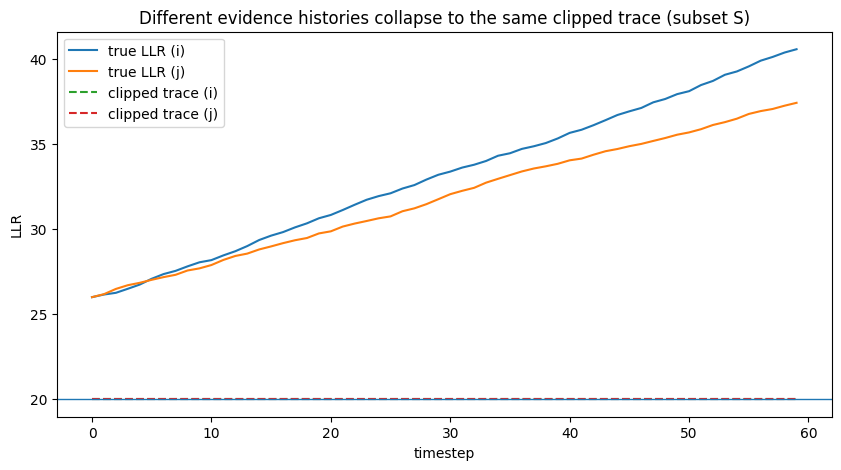

In [13]:
# --- Collapse exhibit and diagnostics ---

mask_allL = np.all(llr_clip == L, axis=1)  # strongest collapse: entire clipped trace identical
idx_allL = np.where(mask_allL)[0]

print("Collapsed subset S = {all timesteps clipped to +L}:")
print("  |S| =", int(idx_allL.size))

# "Unique clipped traces in S" should be exactly 1 (by definition of S)
unique_in_S = len({tuple(row.tolist()) for row in llr_clip[idx_allL]}) if idx_allL.size else 0
print("  Unique clipped traces in S:", unique_in_S)

# Label distribution inside S (must contain both classes to avoid degenerate-AUC objections)
y_S = y[idx_allL]
pos_in_S = int(np.sum(y_S == 1))
neg_in_S = int(np.sum(y_S == 0))
print("  Positive labels in S:", pos_in_S)
print("  Negative labels in S:", neg_in_S)
assert pos_in_S > 0 and neg_in_S > 0, "Degenerate S: need both label classes present within S."

# Pick two samples in S with very different post evidence
if idx_allL.size >= 2:
    i = idx_allL[np.argmax(post_signal[idx_allL])]
    j = idx_allL[np.argmin(post_signal[idx_allL])]
else:
    i, j = 0, 1

print(f"\nTwo samples inside S: i={i}, j={j}")
print("  post_signal[i], post_signal[j] =", float(post_signal[i]), float(post_signal[j]))
print("  final_true differs by:", float(final_true[i] - final_true[j]))
print("  final_clipped:", float(final_clipped[i]), float(final_clipped[j]))
print("  shadow_post differs by:", float(shadow_post[i] - shadow_post[j]))
print("  clipped traces identical?", bool(np.all(llr_clip[i] == llr_clip[j])))
print("  labels y[i], y[j] =", int(y[i]), int(y[j]))

t = np.arange(n_timesteps)
plt.figure(figsize=(10, 5))
plt.plot(t, llr_true[i], label="true LLR (i)")
plt.plot(t, llr_true[j], label="true LLR (j)")
plt.plot(t, llr_clip[i], "--", label="clipped trace (i)")
plt.plot(t, llr_clip[j], "--", label="clipped trace (j)")
plt.axhline(L, linewidth=1)
plt.xlabel("timestep")
plt.ylabel("LLR")
plt.title("Different evidence histories collapse to the same clipped trace (subset S)")
plt.legend()
plt.show()


## Why no function of the clipped trace can separate labels within the collapsed subset

Within S, the clipped trace x = phi(e) is identical for all samples. Therefore:
- Any deterministic model f(x) must output the same prediction for every sample in S.
- The Bayes-optimal predictor given x is constant on S.
- If labels vary within S, the best achievable AUC within S is 0.5 (up to sampling noise).

This is not a model-capacity limitation. It is a many-to-one representation.

Scope: this claim applies to predictors that only observe the clipped value or clipped trace. If additional correlated side channels exist (pre-clip logits, activations, higher-precision accumulators, etc.), that is outside the claim. Adding an explicit shadow channel is a direct way to retain the missing information without storing the unclipped trace.

In [14]:
# --- Train/test split (single split; all evaluations align) ---

idx = np.arange(n_samples)
idx_train, idx_test, y_train, y_test = train_test_split(
    idx, y, test_size=0.30, random_state=0, stratify=y
)

# Baseline feature sets
X_base_scalar = final_clipped.reshape(-1, 1)  # scalar-only baseline
X_base_trace = llr_clip.copy()                # full clipped trace baseline

# Shadow feature (discarded mass after saturation begins)
severity = shadow_post.copy()

# Subset masks on test split
mask_final_sat_test = (final_clipped[idx_test] == L)
mask_allL_test = np.all(llr_clip[idx_test] == L, axis=1)

print("Train / test sizes:", idx_train.size, idx_test.size)
print("Test: final-saturated fraction:", float(mask_final_sat_test.mean()))
print("Test: all-+L-from-start fraction:", float(mask_allL_test.mean()))

# Sanity: within S on test, inputs are identical
if mask_allL_test.any():
    uniq = len({tuple(row.tolist()) for row in llr_clip[idx_test][mask_allL_test]})
    print("Test: unique clipped traces in S:", uniq)

# Extra diagnostics (helps pre-empt "inputs are not identical" objections)
try:
    uniq_test = int(np.unique(llr_clip[idx_test], axis=0).shape[0])
    print("Test: unique clipped traces (overall):", uniq_test)
except Exception:
    pass

Train / test sizes: 4200 1800
Test: final-saturated fraction: 0.7
Test: all-+L-from-start fraction: 0.29944444444444446
Test: unique clipped traces in S: 1
Test: unique clipped traces (overall): 1262


In [15]:
# --- Baseline models and evaluation (overall and within the collapsed subset) ---

def safe_auc(y_true, y_prob):
    # roc_auc_score requires both classes; return NaN if not.
    try:
        return float(roc_auc_score(y_true, y_prob))
    except Exception:
        return float("nan")

def rows_to_table(rows):
    if pd is not None:
        return pd.DataFrame(rows, columns=["Model", "Subset", "Accuracy", "AUC", "n"])
    print("Model | Subset | Accuracy | AUC | n")
    for r in rows:
        print(f"{r[0]:>20} | {r[1]:>10} | {r[2]:>8.3f} | {r[3]:>6.3f} | {r[4]}")
    return None

def eval_model(name, p, y_true, mask_dict):
    yhat = (p >= 0.5).astype(int)
    out = []
    out.append(
        [name, "Overall", float(accuracy_score(y_true, yhat)), safe_auc(y_true, p), int(y_true.size)]
    )
    for subset_name, m in mask_dict.items():
        ys = y_true[m]
        ps = p[m]
        if ys.size:
            out.append(
                [
                    name,
                    subset_name,
                    float(accuracy_score(ys, (ps >= 0.5).astype(int))),
                    safe_auc(ys, ps),
                    int(ys.size),
                ]
            )
        else:
            out.append([name, subset_name, float("nan"), float("nan"), 0])
    return out

def fit_proba_or_constant(clf, X_train, y_train, X_test):
    # LogisticRegression cannot fit a single-class target; fall back to a constant predictor.
    if np.unique(y_train).size < 2:
        dc = DummyClassifier(strategy="constant", constant=int(y_train[0]))
        dc.fit(X_train, y_train)
        return dc.predict_proba(X_test)[:, 1]
    clf.fit(X_train, y_train)
    return clf.predict_proba(X_test)[:, 1]

mask_dict = {"Final-sat": mask_final_sat_test, "All-+L (S)": mask_allL_test}

# Baseline A: scalar final clipped value
clf_scalar = LogisticRegression(max_iter=1000)
p_scalar = fit_proba_or_constant(
    clf_scalar,
    X_base_scalar[idx_train],
    y_train,
    X_base_scalar[idx_test],
)

# Baseline B: full clipped trace
clf_trace = LogisticRegression(max_iter=2000)
p_trace = fit_proba_or_constant(
    clf_trace,
    X_base_trace[idx_train],
    y_train,
    X_base_trace[idx_test],
)

rows = []
rows += eval_model("Baseline scalar", p_scalar, y_test, mask_dict)
rows += eval_model("Baseline trace", p_trace, y_test, mask_dict)

tbl = rows_to_table(rows)
tbl if tbl is not None else None

# Prior sanity check within the collapsed subset S:
# If inputs are identical inside S, any clipped-only model is forced to output a constant.
if mask_allL_test.any():
    ys = y_test[mask_allL_test]
    prior = float(ys.mean())
    p_prior = np.full(ys.shape, prior, dtype=float)
    auc_prior = safe_auc(ys, p_prior)
    acc_prior = max(prior, 1.0 - prior)

    print("\nCollapsed subset S diagnostics:")
    print("  P(y=1 | x) reduces to a constant on S; prior =", prior)
    print("  Constant-prior predictor: accuracy ~= {:.3f}, AUC ~= {:.3f}".format(acc_prior, auc_prior))

    # Explicit AUC for clipped-only baselines restricted to S (test split)
    baseline_auc_S_trace = safe_auc(ys, p_trace[mask_allL_test])
    baseline_auc_S_scalar = safe_auc(ys, p_scalar[mask_allL_test])
    print("  Baseline trace AUC on S (test):", baseline_auc_S_trace)
    print("  Baseline scalar AUC on S (test):", baseline_auc_S_scalar)


Model | Subset | Accuracy | AUC | n
     Baseline scalar |    Overall |    0.506 |  0.517 | 1800
     Baseline scalar |  Final-sat |    0.496 |  0.500 | 1260
     Baseline scalar | All-+L (S) |    0.495 |  0.500 | 539
      Baseline trace |    Overall |    0.516 |  0.519 | 1800
      Baseline trace |  Final-sat |    0.524 |  0.524 | 1260
      Baseline trace | All-+L (S) |    0.495 |  0.500 | 539

Collapsed subset S diagnostics:
  P(y=1 | x) reduces to a constant on S; prior = 0.5046382189239332
  Constant-prior predictor: accuracy ~= 0.505, AUC ~= 0.500
  Baseline trace AUC on S (test): 0.5
  Baseline scalar AUC on S (test): 0.5


Since all representations are identical within S, any predictor depending only on the clipped trace must output a constant score. The observed AUC near 0.5 reflects this representational collapse, not model inadequacy.


## The shadow channel: definition and scope

**What it is:** an online accumulator of the mass that clipping discards after saturation begins (a post-saturation accumulated increment). It uses only quantities already present at runtime:
- the current clipped state,
- the increment Delta_t,
- and the saturation event (whether +L has been reached).

**What it is not:** it does not reconstruct deleted information from nothing, and it does not require storing the unclipped running sum or unclipped logits.

**Limitation:** if the numeric type overflows before clipping is applied (true floating-point overflow), you need earlier clipping, higher precision, or log-domain accumulation. The shadow channel does not address overflow that occurs prior to clipping.

For clarity, this notebook uses non-negative evidence increments and +L clipping. A symmetric construction for +/-L clipping uses two shadow channels (positive overflow and negative underflow) with the same logic.

This construction preserves divergence at the moment information would otherwise be discarded. It does not recover information that was never observed.

## Witness: Identifiability within S using shadow information

In [16]:
# --- Witness: within S, shadow_post alone restores identifiability ---

# Filter to S only
idx_S = idx_allL
y_S = y[idx_S]
X_shadow_S = shadow_post[idx_S].reshape(-1, 1)

# Train/test split inside S
i_S = np.arange(idx_S.size)
i_S_train, i_S_test, y_S_train, y_S_test = train_test_split(
    i_S, y_S, test_size=0.30, random_state=0, stratify=y_S
)

clf_shadow_only = LogisticRegression(max_iter=1000)
clf_shadow_only.fit(X_shadow_S[i_S_train], y_S_train)
p_shadow_only_S = clf_shadow_only.predict_proba(X_shadow_S[i_S_test])[:, 1]

shadow_only_auc_S = float(roc_auc_score(y_S_test, p_shadow_only_S))
print("Witness (shadow_post only): AUC within S (test):", shadow_only_auc_S)


Witness (shadow_post only): AUC within S (test): 0.8220196823976739


This demonstrates that ranking within S is impossible without shadow information and trivial with it, confirming that the failure is representational rather than algorithmic.

In [17]:
# --- Augmented models ---

# Augmented model: clipped scalar plus global shadow feature
X_aug = np.column_stack([final_clipped, severity])

# Standardize using train statistics (avoid leakage)
mu = X_aug[idx_train].mean(axis=0, keepdims=True)
sd = X_aug[idx_train].std(axis=0, keepdims=True) + 1e-12
X_aug_z = (X_aug - mu) / sd

clf_aug = LogisticRegression(max_iter=1000)
p_aug = fit_proba_or_constant(clf_aug, X_aug_z[idx_train], y_train, X_aug_z[idx_test])

# Gated variant: expose shadow information only within the collapsed regime S
is_allL = np.all(llr_clip == L, axis=1).astype(float)
shadow_in_S = shadow_post * is_allL
X_aug_gated = np.column_stack([final_clipped, is_allL, shadow_in_S])

mu2 = X_aug_gated[idx_train].mean(axis=0, keepdims=True)
sd2 = X_aug_gated[idx_train].std(axis=0, keepdims=True) + 1e-12
X_aug_gated_z = (X_aug_gated - mu2) / sd2

clf_aug_gated = LogisticRegression(max_iter=1000)
p_aug_gated = fit_proba_or_constant(
    clf_aug_gated,
    X_aug_gated_z[idx_train],
    y_train,
    X_aug_gated_z[idx_test],
)

rows = []
rows += eval_model("Baseline scalar", p_scalar, y_test, mask_dict)
rows += eval_model("Baseline trace", p_trace, y_test, mask_dict)
rows += eval_model("Augmented (+shadow)", p_aug, y_test, mask_dict)
rows += eval_model("Augmented (+shadow_in_S)", p_aug_gated, y_test, mask_dict)

tbl = rows_to_table(rows)
tbl if tbl is not None else None

Model | Subset | Accuracy | AUC | n
     Baseline scalar |    Overall |    0.506 |  0.517 | 1800
     Baseline scalar |  Final-sat |    0.496 |  0.500 | 1260
     Baseline scalar | All-+L (S) |    0.495 |  0.500 | 539
      Baseline trace |    Overall |    0.516 |  0.519 | 1800
      Baseline trace |  Final-sat |    0.524 |  0.524 | 1260
      Baseline trace | All-+L (S) |    0.495 |  0.500 | 539
 Augmented (+shadow) |    Overall |    0.508 |  0.524 | 1800
 Augmented (+shadow) |  Final-sat |    0.500 |  0.556 | 1260
 Augmented (+shadow) | All-+L (S) |    0.505 |  0.808 | 539
Augmented (+shadow_in_S) |    Overall |    0.576 |  0.634 | 1800
Augmented (+shadow_in_S) |  Final-sat |    0.597 |  0.667 | 1260
Augmented (+shadow_in_S) | All-+L (S) |    0.731 |  0.808 | 539


The interaction term allows the model to use shadow information only within the collapsed regime, avoiding global confounding while remaining a simple linear model.


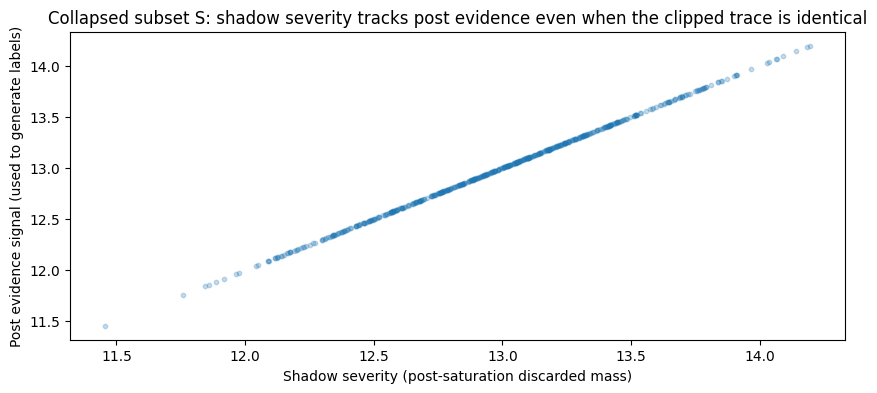

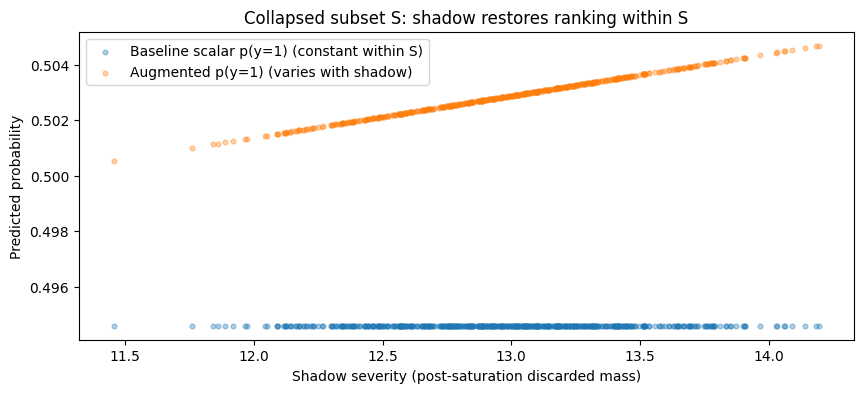

Partial-saturation subset (final-sat but not all-+L): n = 721
  Baseline trace AUC on this subset: 0.5505332656170645
  Baseline scalar AUC on this subset: 0.5
  Augmented (+shadow) AUC on this subset: 0.4955676624036198


In [18]:
# --- Visual intuition: within S, baselines must tie; shadow varies ---

sev_test = severity[idx_test]
post_test = post_signal[idx_test]

plt.figure(figsize=(10, 4))
plt.scatter(sev_test[mask_allL_test], post_test[mask_allL_test], s=10, alpha=0.25)
plt.xlabel("Shadow severity (post-saturation discarded mass)")
plt.ylabel("Post evidence signal (used to generate labels)")
plt.title("Collapsed subset S: shadow severity tracks post evidence even when the clipped trace is identical")
plt.show()

plt.figure(figsize=(10, 4))
plt.scatter(
    sev_test[mask_allL_test],
    p_scalar[mask_allL_test],
    s=12,
    alpha=0.35,
    label="Baseline scalar p(y=1) (constant within S)",
)
plt.scatter(
    sev_test[mask_allL_test],
    p_aug[mask_allL_test],
    s=12,
    alpha=0.35,
    label="Augmented p(y=1) (varies with shadow)",
)
plt.xlabel("Shadow severity (post-saturation discarded mass)")
plt.ylabel("Predicted probability")
plt.title("Collapsed subset S: shadow restores ranking within S")
plt.legend()
plt.show()

# Optional sanity: the baseline trace can still learn in the partially collapsed region
mask_partial = mask_final_sat_test & (~mask_allL_test)
if mask_partial.any():
    print("Partial-saturation subset (final-sat but not all-+L): n =", int(mask_partial.sum()))
    print("  Baseline trace AUC on this subset:", safe_auc(y_test[mask_partial], p_trace[mask_partial]))
    print("  Baseline scalar AUC on this subset:", safe_auc(y_test[mask_partial], p_scalar[mask_partial]))
    print("  Augmented (+shadow) AUC on this subset:", safe_auc(y_test[mask_partial], p_aug[mask_partial]))


## The ZIA connection

Clipping collapses distinct evidence histories to the same stored value or trace. A shadow channel restores identifiability by recording the discarded mass online.

ZIA goes further by providing a composable algebra in which saturated states carry an explicit divergence index, so ratio queries reduce to ordinary real arithmetic on those indices.

Key rule (as used here): infinity / infinity reduces to a ratio of divergence indices.

Ratios are only well-defined when saturated values share a common divergence reference. In practice, this means storing a log-divergence index alongside the clipped value.

Numerical practicality: instead of storing a = exp(log_index) directly (which can overflow), store a shifted log-index, exponentiate after subtracting a global reference, and rely on the fact that the reference cancels in ratios.

In [19]:
# --- ZIA ratio demonstration with log-index shifting to avoid overflow ---

# Define a log-index (in this demo: log_index == severity == shadow_post)
log_index = severity.copy()

# Choose a global reference so exp(log_index - shift) is <= 1 for all samples
shift = float(np.max(log_index))
a_scaled = np.exp(log_index - shift)  # values in (0, 1]

def to_zia_inf_from_scaled_index(a):
    # ZIA infinity token with divergence index a
    return zia.ZValue.infinity(float(a))

# Pick i, j from the collapsed subset (if available)
if idx_allL.size >= 2:
    i = idx_allL[np.argmax(log_index[idx_allL])]
    j = idx_allL[np.argmin(log_index[idx_allL])]
else:
    i, j = 0, 1

Zi = to_zia_inf_from_scaled_index(a_scaled[i])
Zj = to_zia_inf_from_scaled_index(a_scaled[j])

# In ZIA, infinity / infinity reduces to a ratio of divergence indices
R_zia = float(Zi / Zj)

# The shift cancels, so the expected ratio is exp(log_index[i] - log_index[j])
R_expected = float(np.exp(log_index[i] - log_index[j]))

print("Using samples i, j =", int(i), int(j))
print("  log_index[i], log_index[j] =", float(log_index[i]), float(log_index[j]))
print("  shift =", shift)
print("  a_scaled[i], a_scaled[j] =", float(a_scaled[i]), float(a_scaled[j]))
print("  R_zia      =", R_zia)
print("  R_expected =", R_expected)
print("  abs error  =", abs(R_zia - R_expected))

Using samples i, j = 2672 1153
  log_index[i], log_index[j] = 14.57637314841533 11.425913348970928
  shift = 14.57637314841533
  a_scaled[i], a_scaled[j] = 1.0 0.042832428012023624
  R_zia      = 23.3467969576529
  R_expected = 23.3467969576529
  abs error  = 0.0


In [20]:
# --- Final sanity check (witness for the representational claim) ---

print("Final sanity check:")

# Keep your original global-S counts if you want them
print("  Both label classes occur within S? ", (pos_in_S > 0) and (neg_in_S > 0))
print("  pos_in_S =", pos_in_S, "| neg_in_S =", neg_in_S)

# Now do the *test-split* version (the one baseline_auc_S actually refers to)
nS_test = int(mask_allL_test.sum())
print("  n in S (test split):", nS_test)

if nS_test > 0:
    ys = y_test[mask_allL_test]
    posS = int((ys == 1).sum())
    negS = int((ys == 0).sum())
    print("  Both label classes occur within S (test)?", (posS > 0) and (negS > 0))
    print("  pos_in_S_test =", posS, "| neg_in_S_test =", negS)

    baseline_auc_S = safe_auc(ys, p_trace[mask_allL_test])
    print("  Baseline AUC within S (trace, test):", baseline_auc_S)

    print("  Shadow-only AUC within S (test):", shadow_only_auc_S)
else:
    print("  Baseline AUC within S (trace, test): n/a (S is empty in test split)")
    print("  Shadow-only AUC within S (test): n/a (S is empty in test split)")

Final sanity check:
  Both label classes occur within S?  True
  pos_in_S = 877 | neg_in_S = 904
  n in S (test split): 539
  Both label classes occur within S (test)? True
  pos_in_S_test = 272 | neg_in_S_test = 267
  Baseline AUC within S (trace, test): 0.5
  Shadow-only AUC within S (test): 0.8220196823976739


## Final sanity check

- Baseline AUC within S is approximately 0.5.
- Shadow-only AUC within S is significantly greater than 0.5.
- Both label classes occur within S.
- The notebook makes no claims beyond what the printed diagnostics demonstrate.

## Summary

- Clipping stabilizes training and inference, but it can collapse distinct evidence histories to identical stored values, and in some regimes to identical stored traces.
- Within the collapsed subset S where the clipped trace is constant (for example, all +L), no function of the clipped trace can rank or separate labels unless labels are constant on S. In that case, the Bayes-optimal predictor on S reduces to a constant, so AUC on S is 0.5 (up to sampling noise).
- A shadow channel that records post-saturation discarded mass is a direct engineering response: it uses only runtime quantities and does not require storing unclipped logits.
- The shadow restores identifiability within the collapsed subset, so models can again rank saturated cases.
- With ZIA-style saturated states carrying divergence indices, ratio queries between saturated states reduce to ordinary arithmetic on those indices. This can be implemented safely using log-index shifting.